In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, shapiro, skew
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, AffinityPropagation
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA, TruncatedSVD
import plotly.express as px
import umap
import seaborn as sns
import optuna
import warnings
from collections import defaultdict
warnings.filterwarnings("ignore")
# pd.set_option('display.max_rows', None)

/home/otvorot/exercises/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# «Лаборатории исследований гражданского общества». Определение уязвимых групп населения

задача:
 - кластеризовать регионы России и определить, какие из них наиболее
остро нуждаются в помощи малообеспеченным/неблагополучным
слоям населения;
 - описать группы населения, сталкивающиеся с бедностью;

определить:
 - влияет ли число детей, пенсионеров и других социально уязвимых
групп на уровень бедности в регионе;
 - связаны ли уровень бедности/социального неблагополучия с
производством и потреблением в регионе;
 - какие ещё зависимости можно наблюдать относительно социально незащищённых слоёв населения.

Данные и краткое описание:
 - *child_mortality_rural_1990_2021.xls* — число умерших на первом году
жизни детей за год, по всем регионам, в сельской местности.
 - *child_mortality_urban_1990_2021.xls* — число умерших на первом году
жизни детей за год, по всем регионам, в городской местности.
 - *disabled_total_by_age_2017_2022.csv* — число людей с инвалидностью
по регионам, по месяцам, по возрастным группам.
 - *morbidity_2005_2020_age_disease.xls* — заболеваемость на 100 тыс.
человек населения, по возрастным группам и группам заболеваний.
 - *poverty_percent_by_regions_1992_2020.csv* — процент людей, живущих за чертой
бедности (с денежными доходами ниже величины прожиточного минимума), оценка за год по регионам.
 - *welfare_expense_share_2015_2020* - расходы на социальную политику от
общих расходов бюджета региона, % в год
 - *cash_real_income_wages_2015_2020* - среднедушевые и реальные денежные доходы населения, номинальная и реальная начисленная
зарплата, по регионам.
 - *poverty_socdem_20*.xls* - распределениe малоимущего населения по социально-демографическим группам (дети трудящиеся, пенсионеры) за 2017–2020 гг., по регионам.
 - *housing_2020* - характеристика жилищных условий домохозяйств. Оценка домохозяйствами состояния помещения, обследование 2020 года.
 - *population.xlsx* - численность населения по регионам и федеральным округам на 1 января каждого года за 1999–2022 гг.
 - *gross_regional_product_1996_2020.xls* - валовой региональный продукт на душу населения, в рублях.
 - *regional_production_*_*.csv* - объём отгруженх товаров собственного производства или услуг, выполненных собственными силами, по видам деятельности (в тысячах рублей за год).
 - *retail_turnover_per_capita_2000_2021.xls* - оборотрозничной совершённыхотдельными
торговли на душу населения, в рублях.
 - *папка crimes* - сведения о преступлениях,
категориями лиц за 2016–2022 гг., по месяцам, регионам, категориям лиц, категориям преступлений.
 - *drug_alco* - сведения о заболеваемости алкоголизмом и наркоманией, на 100
тыс. населения (2005–2018).
 - *newborn_2006_2022_monthly.csv* - рождённые в этом месяце, по регионам, без
учёта мертворождённых.
 - *workers.csv* — отношение числа занятых в экономике региона к численности
населения региона в трудоспособном возрасте, %, 2012–2020 гг.
 - *bezrabotn.xlsx* - уровень безработицы

## 1. Формирование датасета

*Данные должны быть актуальными и из одного временного диапазона. Все таблицы сводятся к периоду с 2017 по 2020 года. Было странно оценивать один признак с 99 года, а информацию из другого ограничить 2015 например. Остановлюсь на этом предположении. Рассматривать данные в формате временных рядов не вижу смысла*

In [2]:
base = pd.read_excel("data/base_population.xlsx")
base["population_coef"] = base.apply(
    lambda row: row["январь 2021 г."] / row["январь 2018 г."], axis=1
)
base = base.iloc[:, [0, 7, 8]]
base.columns = ["region", "population", "population_coef"]

In [3]:
child_mort_vila = pd.read_excel(
    "data/child_mortality_rural_1990_2021.xls",
    header=2,
    usecols=[0, 30, 33]
)
child_mort_vila["chld_mort_vila_coef"] = child_mort_vila.apply(
    lambda row: row["2020"] - row["2017"], axis=1
)
child_mort_vila.drop(columns="2017", inplace=True)
child_mort_vila.columns = ["region", "child_mort_vila", "child_mort_vila_coef"]
child_mort_vila["region"] = child_mort_vila["region"].apply(lambda x: x.strip())
base = pd.merge(
    base,
    child_mort_vila,
    "left",
    "region"
)

In [4]:
child_mort_city = pd.read_excel(
    "data/child_mortality_urban_1990_2021.xls",
    header=2,
    usecols=[0, 30, 33]
)
child_mort_city["chld_mort_selo"] = child_mort_city.apply(
    lambda row: row["2020"] - row["2017"], axis=1
)
child_mort_city.drop(columns="2017", inplace=True)
child_mort_city.columns = ["region", "child_mort_city", "child_mort_selo_coef"]
child_mort_city["region"] = child_mort_city["region"].apply(lambda x: x.strip())
base = pd.merge(
    base,
    child_mort_city,
    "left",
    "region"
)

In [5]:
cash_income = pd.read_excel("data/cash_real_income_wages_2015_2020.xlsx", usecols=[0, 3, 4, 5, 6])
cash_income["region"] = cash_income["region"].apply(lambda x: x.replace('\n', ' '))
repl = {
    'Архангельская область без автономного округа': 'Архангельская область (кроме Ненецкого автономного округа)',
    'Кемеровская область': 'Кемеровская область - Кузбасс',
    'Ненецкий автономный округ': 'Ненецкий автономный округ (Архангельская область)',
    'Республика Адыгея': 'Республика Адыгея (Адыгея)',
    'Республика Татарстан': 'Республика Татарстан (Татарстан)',
    'Тюменская область без автономных округов': 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)',
    'Ханты-Мансийский  автономный округ - Югра': 'Ханты-Мансийский автономный округ - Югра (Тюменская область)',
    'Чувашская Республика': 'Чувашская Республика - Чувашия',
    'Ямало-Ненецкий  автономный округ': 'Ямало-Ненецкий автономный округ (Тюменская область)',
    'г. Москва': 'Город Москва столица Российской Федерации город федерального значения',
    'г. Санкт-Петербург': 'Город Санкт-Петербург город федерального значения',
    'г. Севастополь': 'Город федерального значения Севастополь'
}
cash_income["region"] = cash_income["region"].apply(lambda x: x if x not in repl else repl[x])
cash_income["cash_income_coef"] = cash_income.apply(
    lambda row: row[2020] / row[2017],
    axis=1
)
cash_income.drop(columns=[2017, 2018, 2019], inplace=True)
cash_income.columns = ["region", "cash_income", "cash_income_coef"]
base = pd.merge(
    base,
    cash_income,
    "left",
    "region"
)

In [6]:
mean_salary = pd.read_excel(
    "data/cash_real_income_wages_2015_2020.xlsx",
    usecols=[0, 3, 4, 5, 6],
    sheet_name=2
)
mean_salary["region"] = mean_salary["region"].apply(lambda x: x.replace('\n', ' '))
mean_salary["region"] = mean_salary["region"].apply(lambda x: x if x not in repl else repl[x])
mean_salary["cash_income_coef"] = mean_salary.apply(
    lambda row: row[2020] / row[2017],
    axis=1
)
mean_salary.drop(columns=[2017, 2018, 2019], inplace=True)
mean_salary.columns = ["region", "mean_salary", "salary_coef"]
base = pd.merge(
    base,
    mean_salary,
    "left",
    "region"
)

In [7]:
disabled = pd.read_csv("data/disabled_total_by_age_2017_2022.csv", parse_dates=["date"])
disabled["year"] = disabled["date"].dt.year
disabled["month"] = disabled["date"].dt.month
disabled["day"] = disabled["date"].dt.day
disabled_filt = disabled.query("year == 2021 and month == 1 and day == 1")
disabled_filt["disable_sub40"] = disabled_filt.apply(
    lambda row: (row["18_30"] + row["31_40"]) / row["total"], axis=1
)
disabled_filt = disabled_filt[["region", "disable_sub40"]]
repl = {
    'Архангельская область без автономного округа': 'Архангельская область (кроме Ненецкого автономного округа)',
    'Кемеровская область': 'Кемеровская область - Кузбасс',
    'Ненецкий автономный округ': 'Ненецкий автономный округ (Архангельская область)',
    'Республика Адыгея': 'Республика Адыгея (Адыгея)',
    'Республика Татарстан': 'Республика Татарстан (Татарстан)',
    'Тюменская область без автономных округов': 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)',
    'Ханты-Мансийский автономный округ': 'Ханты-Мансийский автономный округ - Югра (Тюменская область)',
    'Чувашская Республика': 'Чувашская Республика - Чувашия',
    'Ямало-Ненецкий автономный округ': 'Ямало-Ненецкий автономный округ (Тюменская область)',
    'город Москва': 'Город Москва столица Российской Федерации город федерального значения',
    'город Санкт-Петербург': 'Город Санкт-Петербург город федерального значения',
    'город Севастополь': 'Город федерального значения Севастополь'
}
disabled_filt["region"] = disabled_filt["region"].apply(lambda x: x if x not in repl else repl[x])
base = pd.merge(
    base,
    disabled_filt,
    "left",
    "region"
)

In [8]:
gross = pd.read_excel(
    "data/gross_regional_product_1996_2020.xls",
    skiprows=2,
    usecols=[0, 22, 25]
)
gross["gross_coef"] = gross.apply(lambda row: row["2020"] / row["2017"], axis=1)
gross.drop(columns=["2017"], inplace=True)
gross.columns = ["region", "gross", "gross_coef"]
gross["region"] = gross["region"].apply(lambda x: x.strip())
base = pd.merge(
    base,
    gross,
    "left",
    "region"
)

In [9]:
housing1 = pd.read_excel("data/housing_2020.xlsx", usecols=[0, 7])
housing2 = pd.read_excel(
    "data/housing_2020.xlsx",
    sheet_name=1,
    usecols=[0, 5, 13]
)
housing = pd.merge(
    housing1,
    housing2,
    "left",
    "Регион"
)
housing.rename(columns={
    "Регион": "region",
    'из них указавшие: на плохое состояние или очень плохое состояние жилого помещения и на стесненность проживания': "плохое состояние или очень плохое состояние жилого помещения и стесненность проживания"
    },
    inplace=True
)
housing["region"] = housing["region"].apply(lambda x: x.strip())
repl = {
    'Bладимирская область': 'Владимирская область',
    'Bолгоградская область': 'Волгоградская область',
    'Bологодская область': 'Вологодская область',
    'Bоронежская область': 'Воронежская область',
    'Республика Саха(Якутия)': 'Республика Саха (Якутия)',
    'Чукотский авт. округ': 'Чукотский автономный округ',
    'Еврейская авт. область': 'Еврейская автономная область',
    'Архангельская область без авт. округа': 'Архангельская область (кроме Ненецкого автономного округа)',
    'Кемеровская область': 'Кемеровская область - Кузбасс',
    'Ненецкий авт. округ': 'Ненецкий автономный округ (Архангельская область)',
    'Республика Адыгея': 'Республика Адыгея (Адыгея)',
    'Республика Татарстан': 'Республика Татарстан (Татарстан)',
    'Тюменская область без авт. округов': 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)',
    'Ханты-Мансийский авт. округ': 'Ханты-Мансийский автономный округ - Югра (Тюменская область)',
    'Чувашская Республика': 'Чувашская Республика - Чувашия',
    'Ямало-Ненецкий авт. округ': 'Ямало-Ненецкий автономный округ (Тюменская область)',
    'г.Москва': 'Город Москва столица Российской Федерации город федерального значения',
    'г. Санкт-Петербург': 'Город Санкт-Петербург город федерального значения',
    'г. Севастополь': 'Город федерального значения Севастополь'
}
housing.columns = ["region", "live_area", "apartment_bad", "apartment_keep"]
housing["region"] = housing["region"].apply(lambda x: x if x not in repl else repl[x])
base = pd.merge(
    base,
    housing,
    "left",
    "region"
)

In [10]:
born = pd.read_csv("data/newborn_2006_2022_monthly.csv", sep=';')
cols = [0]
for i, col in enumerate(born.columns):
    x = col.strip().split()
    if "декабрь" in x and ("2021" in x or "2018" in x):
        cols.append(i)
born = born.iloc[:, cols]
born.dropna(how="any", axis=0, inplace=True)
born["декабрь 2018 г."] = born["декабрь 2018 г."].apply(lambda x: round(float(x.replace(",", "."))))
born["декабрь 2021 г."] = born["декабрь 2021 г."].apply(lambda x: round(float(x.replace(",", "."))))
born["born_coef"] = born.apply(lambda row: row["декабрь 2021 г."] / row["декабрь 2018 г."], axis=1)
born.rename(columns={"декабрь 2021 г.": "born", "Region": "region"}, inplace=True)
base = pd.merge(
    base,
    born.iloc[:, [0, 2, 3]],
    'left',
    'region'
)

In [11]:
pover_perc = pd.read_csv("data/poverty_percent_by_regions_1992_2020.csv")
pover_perc["region"] = pover_perc["region"].str.strip()
pover_perc = pover_perc.query("year == 2020").iloc[:, [0, 2]]
base = pd.merge(
    base,
    pover_perc,
    'left',
    'region'
)

In [12]:
regProd = pd.read_csv("data/regional_production_2017_2020.csv")
regProd["production_field"] = regProd["production_field"].str.strip()
regProd["region"] = regProd["region"].str.strip()
minerals = regProd.query("production_field == 'ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ'")[["region", "2020"]]
electrify = regProd.query(
    "production_field == 'ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА'"
)[["region", "2020"]]
waters = regProd.query(
    "production_field == 'ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ'"
)[["region", "2020"]]
prom = regProd.query("production_field == 'Промышленное производство (промышленность)'")[["region", "2020"]]
minerals.rename(columns={"2020": "minerals"}, inplace=True)
electrify.rename(columns={"2020": "electrify"}, inplace=True)
waters.rename(columns={"2020": "waters"}, inplace=True)
prom.rename(columns={"2020": "prom"}, inplace=True)
base = pd.merge(
    base,
    minerals,
    'left',
    'region'
)
base = pd.merge(
    base,
    electrify,
    'left',
    'region'
)
base = pd.merge(
    base,
    waters,
    'left',
    'region'
)
base = pd.merge(
    base,
    prom,
    'left',
    'region'
)

In [13]:
retail = pd.read_excel(
    "data/retail_turnover_per_capita_2000_2021.xls",
    skiprows=2,
    usecols=[0, 22]
)
retail = retail.iloc[1:]
retail.columns = ["region", "retail"]
retail["region"] = retail["region"].str.strip()
base = pd.merge(
    base,
    retail,
    'left',
    'region'
)

In [14]:
poverty_socdem = pd.read_excel("data/poverty_socdem_2020.xls", skiprows=2, usecols=[0, 2, 3])
poverty_socdem.columns = ["region", "chlds_poverty", "olds_poverty"]
poverty_socdem["region"] = poverty_socdem["region"].str.strip()
base = pd.merge(
    base,
    poverty_socdem,
    'left',
    'region'
)

In [15]:
unemploy = pd.read_excel(
    "data/bezrabotn.xlsx",
    sheet_name=2,
    skiprows=4,
    usecols=[0, 4]
)
unemploy.columns = ["region", "unemploy"]
unemploy["region"] = unemploy["region"].str.strip()
repl = {
    'Архангельская область без авт. округа': 'Архангельская область (кроме Ненецкого автономного округа)',
    'Кемеровская область': 'Кемеровская область - Кузбасс',
    'Республика Адыгея': 'Республика Адыгея (Адыгея)',
    'Республика Северная Осетия - Алания': 'Республика Северная Осетия-Алания',
    'Республика Татарстан': 'Республика Татарстан (Татарстан)',
    'Тюменская область без авт. округов': 'Тюменская область (кроме Ханты-Мансийского автономного округа-Югры и Ямало-Ненецкого автономного округа)',
    'Чувашская Республика': 'Чувашская Республика - Чувашия',
    'Ямало-Ненецкий автономный округ': 'Ямало-Ненецкий автономный округ (Тюменская область)',
    'в том числе: \nНенецкий автономный округ': 'Ненецкий автономный округ (Архангельская область)',
    'в том числе: \nХанты-Мансийский автономный округ - Югра': 'Ханты-Мансийский автономный округ - Югра (Тюменская область)',
    'г. Москва': 'Город Москва столица Российской Федерации город федерального значения',
    'г. Севастополь': 'Город федерального значения Севастополь',
    'г.Санкт-Петербург': 'Город Санкт-Петербург город федерального значения'}
unemploy["region"] = unemploy["region"].apply(lambda x: repl[x] if x in repl else x)
base = pd.merge(
    base,
    unemploy,
    'left',
    'region'
)

In [16]:
crime = pd.read_excel("data/4-EGS_Razdel_4_122020.xls", skiprows=9)
crime = crime.iloc[2:, 1:]
crime["opg"] = crime.apply(
    lambda row: row["группой лиц\n"]
                + row["группой лиц по предварительному сговору\n"]
                + row["организованной группой\n"]
                + row["преступным сообществом (преступной организацией)\n"],
    axis=1
)
crime["intoxicated"] = crime.apply(
    lambda row: row["алкогольного\n"]
                + row["наркотического\n"]
                + row["токсического\n"],
    axis=1
)
crime = crime.iloc[:, [0, 1, 2, -1, -2]]

crime1 = pd.read_excel("data/4-EGS_Razdel_4_122020.xls", sheet_name=1, skiprows=9)
crime1 = crime1.iloc[2:, 1:]
crime1["opg"] = crime1.apply(
    lambda row: row["группой лиц\n"]
                + row["группой лиц по предварительному сговору\n"]
                + row["организованной группой\n"]
                + row["преступным сообществом (преступной организацией)\n"],
    axis=1
)
crime1["intoxicated"] = crime1.apply(
    lambda row: row["алкогольного\n"]
                + row["наркотического\n"]
                + row["токсического\n"],
    axis=1
)
crime1 = crime1.iloc[:, [0, 1, 2, -1, -2]]

crime2 = pd.read_excel("data/4-EGS_Razdel_4_122020.xls", sheet_name=2, skiprows=9)
crime2 = crime2.iloc[2:, 1:]
crime2["opg"] = crime2.apply(
    lambda row: row["группой лиц\n"]
                + row["группой лиц по предварительному сговору\n"]
                + row["организованной группой\n"]
                + row["преступным сообществом (преступной организацией)\n"],
    axis=1
)
crime2["intoxicated"] = crime2.apply(
    lambda row: row["алкогольного\n"]
                + row["наркотического\n"]
                + row["токсического\n"],
    axis=1
)
crime2 = crime2.iloc[:, [0, 1, 2, -1, -2]]

In [17]:
tyagota = pd.merge(
    crime1,
    crime2,
    'left',
    'Unnamed: 1'
)
tyagota["young_crime_hard"] = tyagota["несовершеннолетними или при их соучастии\n_x"] \
    + tyagota["несовершеннолетними или при их соучастии\n_y"]

tyagota["recediv_hard"] = tyagota["ранее совершавшими преступления\n_x"] \
    + tyagota["ранее совершавшими преступления\n_y"]

tyagota["intoxicated_hard"] = tyagota["intoxicated_x"] + tyagota["intoxicated_y"]
tyagota["opg_hard"] = tyagota["opg_x"] + tyagota["opg_y"]
tyagota = tyagota.iloc[:, [0, -4, -3, -2, -1]]
crime = pd.merge(
    crime,
    tyagota,
    'left',
    'Unnamed: 1'
)
crime["young_crime_hard"] = crime["young_crime_hard"] / crime["несовершеннолетними или при их соучастии\n"]
crime["recediv_hard"] = crime["recediv_hard"] / crime["ранее совершавшими преступления\n"]
crime["intoxicated_hard"] = crime["intoxicated_hard"] / crime["intoxicated"]
crime["opg_hard"] = crime["opg_hard"] / crime["opg"]
crime["total_crime"] = crime.iloc[:, [1, 2, 3, 4]].sum(axis=1)
crime = crime.iloc[:, [0, 5, 6, 7, 8, 9]]
crime.rename(columns={'Unnamed: 1': 'region'}, inplace=True)
crime["region"] = crime["region"].str.strip()
repl = {
    'Кемеровская область – Кузбасс': 'Кемеровская область - Кузбасс',
    'Ненецкий автономный округ': 'Ненецкий автономный округ (Архангельская область)',
    'Новгородская  область': 'Новгородская область',
    'Республика Адыгея': 'Республика Адыгея (Адыгея)',
    'Республика Северная Осетия – Алания': 'Республика Северная Осетия-Алания',
    'Республика Татарстан': 'Республика Татарстан (Татарстан)',
    'Ханты-Мансийский автономный округ –  Югра': 'Ханты-Мансийский автономный округ - Югра (Тюменская область)',
    'Чувашская Республика': 'Чувашская Республика - Чувашия',
    'Ямало-Ненецкий автономный округ': 'Ямало-Ненецкий автономный округ (Тюменская область)',
    'г. Москва': 'Город Москва столица Российской Федерации город федерального значения',
    'г. Санкт-Петербург': 'Город Санкт-Петербург город федерального значения',
    'г. Севастополь': 'Город федерального значения Севастополь'
}
crime["region"] = crime["region"].apply(lambda x: repl[x] if x in repl else x)
base = pd.merge(
    base,
    crime,
    'left',
    'region'
)
base["total_crime"] = base['total_crime'] / base['population']

## Признаки итогового датасета:
 - ***region*** - субъект Российской Федерации
 - ***population*** / ***population_coef*** - численность населения и коэффициент роста (здесь и далее показатель 2020 года делится на показатель 2017)
 - ***child_mort_vila*** / ***coef*** / ***child_mort_city*** / ***coef*** - смертность на превом году детей в селах и городах соответственно / абсолютная разница между 2020 и 2017 годами
 - ***cash_income*** / ***coef*** - средний доход и коэффициент показателя роста среднего дохода
 - ***mean_salary*** / ***coef*** - средние зарплаты и коэффциент
 - ***disable_sub40*** - отношение инвалидов до 40 лет к количеству всех людей с инвалидностью в регионе
 - ***gross*** / ***coef*** - валовой региональный продукт на душу населения, в рублях и коэффициент
 - ***live_area*** - жилая площадь на человека
 - ***apartment_bad*** - плохое состояние жилища
 - ***apartment_keep*** - число людей не собирающихся менять жилищные условия
 - ***born*** / ***coef*** - рождённые и коэффициент
 - ***poverty_percent*** - процент людей, живущих за чертой бедности (с денежными доходами ниже величины прожиточного минимума)
 - ***minerals*** - ДОБЫЧА ПОЛЕЗНЫХ ИСКОПАЕМЫХ
 - ***electrify*** - ОБЕСПЕЧЕНИЕ ЭЛЕКТРИЧЕСКОЙ ЭНЕРГИЕЙ, ГАЗОМ И ПАРОМ; КОНДИЦИОНИРОВАНИЕ ВОЗДУХА
 - ***waters*** - ВОДОСНАБЖЕНИЕ; ВОДООТВЕДЕНИЕ, ОРГАНИЗАЦИЯ СБОРА И УТИЛИЗАЦИИ ОТХОДОВ, ДЕЯТЕЛЬНОСТЬ ПО ЛИКВИДАЦИИ ЗАГРЯЗНЕНИЙ
 - ***prom*** - Промышленное производство (промышленность)
 - ***retail*** - оборот розничной торговли на душу населения, в рублях.
 - ***chlds_poverty*** и ***olds_poverty*** - дети за чертой бедности и старики соответственно
 - ***unemploy*** - процент безработных возраста 15 лет и старше
 - ***young_crime_hard***	- отношение тяжких и особо тяжких преступлений совершенных несовершеннолетними
 - ***recediv_hard***	- отношение тяжких и особо тяжких преступлений повторно совершенных
 - ***intoxicated_hard***	- отношение тяжких и особо тяжких преступлений совершенных гражданами в состоянии алкогольного, наркотического или другого опьянения
 - ***opg_hard***	- отношение тяжких и особо тяжких преступлений совершенных группами лиц
 - ***total_crime*** - отношение числа совершенных преступлений в регионе к численности населения

# 2. Подготовка датасета

In [18]:
states = pd.read_excel("data/fo.xls")
states.columns = ['region', 'fo']
base = pd.merge(
    base,
    states,
    'left',
    'region'
)

base = base[
    ~base['region'].isin(['Архангельская область', 'Тюменская область'])
]

base['retail'] = base['retail'].astype('int64')
medians = defaultdict(dict)
cols = base.iloc[:, 1:33].columns
for fo in base.fo.unique():
    x = base[base['fo'] == fo]
    for column in cols:
        medians[fo][column] = base[column].median()

for index, row in base.iterrows():
    for col in cols:
        if pd.isna(row[col]):
            base.loc[index, col] = medians[row.fo][col]
federal_okruga = base.fo
base.drop(columns=['fo'], inplace=True)
final = base.copy()

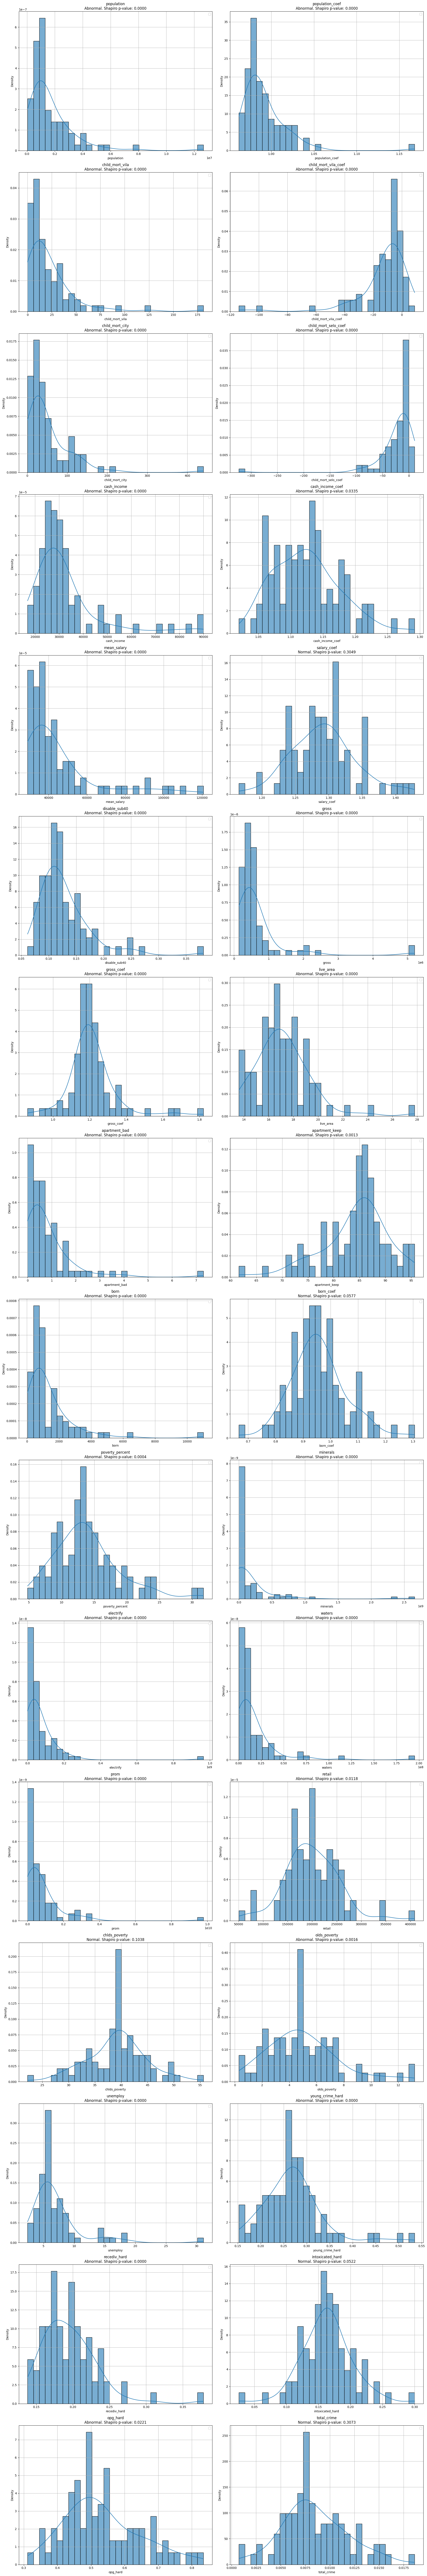

In [19]:
cols = final.columns[1:]
n_cols = 2
n_rows = int(len(cols) / 2)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 120))
axes = axes.flatten()
for i, column in enumerate(cols):
    ax = axes[i]
    sns.histplot(final[column], kde=True, bins=30, stat='density', ax=ax, alpha=0.6)
    _, p_value = shapiro(final[column])
    if p_value < 0.05:
        ax.set_title(f'{column}\nAbnormal. Shapiro p-value: {p_value:.4f}')
    else:
        ax.set_title(f'{column}\nNormal. Shapiro p-value: {p_value:.4f}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

*выше я заполнил пропуски в соответствии с распределением по округам. Можно было использовать среднее по округу, но я решил заполнить медианой. Так-же удалил строки с Архангельской и Тюменской областью, где в их состав включены другие регионы. Плстроил графики показывающие распределения по признакам вместе со статтестом. Большинство признаков не имеют нормального распределения и присутствуют значения которое можно считать выбросами. Из-за невозможности избавиться от них в дальнейшем я буду применять робастный скейлер*

# 3. Выбор модели и подбор гиперпараметров

*Ниже проведу подбор гиперпараметров с помощью оптуна*

In [20]:
X = final.drop(columns=['region'])
y = final['region']
uma = umap.UMAP(n_components=4, random_state=10).fit_transform(X.copy())
s = RobustScaler().fit_transform(uma.copy())
X_rob = umap.UMAP(n_components=3, random_state=8).fit_transform(s.copy())

In [21]:
# kmeans
def objective(trial):
    n_clusters = trial.suggest_int("n_clusters", 2, 10)
    algorithm = trial.suggest_categorical("algorithm", ['lloyd', 'elkan'])
    init = trial.suggest_categorical("init", ['k-means++', 'random'])
    kmeans = KMeans(
        n_clusters=n_clusters,
        init=init,
        algorithm=algorithm,
        random_state=42
    )
    kmeans.fit(X_rob)
    sil = silhouette_score(X_rob, kmeans.labels_)
    dav = davies_bouldin_score(X_rob, kmeans.labels_)
    return sil, dav

study_kmeans = optuna.create_study(directions=["maximize", "minimize"])
study_kmeans.optimize(objective, n_trials=80, n_jobs=-1)

# agglomerative
def objective(trial):
    n_clusters = trial.suggest_int("n_clusters", 2, 10)
    linkage = trial.suggest_categorical("linkage", ["ward", "complete", "average", "single"])
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    labels = model.fit_predict(X_rob)
    sil = silhouette_score(X_rob, labels)
    dav = davies_bouldin_score(X_rob, labels)
    return sil, dav

study_agglo = optuna.create_study(directions=["maximize", "minimize"])
study_agglo.optimize(objective, n_trials=80, n_jobs=-1)

# gaussian
def objective(trial):
    n_components = trial.suggest_int("n_components", 2, 10)
    covariance_type = trial.suggest_categorical("covariance_type", ["full", "tied", "diag", "spherical"])
    model = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=42)
    labels = model.fit_predict(X_rob)
    sil = silhouette_score(X_rob, labels)
    dav = davies_bouldin_score(X_rob, labels)
    return sil, dav

study_gaussian = optuna.create_study(directions=["maximize", "minimize"])
study_gaussian.optimize(objective, n_trials=80, n_jobs=-1)

# affinity
def objective(trial):
    damping = trial.suggest_float("damping", 0.5, 0.99)
    preference = trial.suggest_float("preference", -50, 0)
    clustering = AffinityPropagation(
        damping=damping,
        preference=preference,
        random_state=42
    )
    labels = clustering.fit_predict(X_rob)
    if len(set(labels)) > 1 and len(set(labels)) < 84:
        return silhouette_score(X_rob, labels)
    return -1

study_affinity = optuna.create_study(direction="maximize")
study_affinity.optimize(objective, n_trials=80, n_jobs=-1)

# spectral
def objective(trial):
    n_clusters = trial.suggest_int("n_clusters", 2, 10)
    eigen_solver = trial.suggest_categorical("eigen_solver", ['arpack', 'lobpcg', 'amg'])
    affinity = trial.suggest_categorical("affinity", ["rbf", "nearest_neighbors"])
    gamma = trial.suggest_float("gamma", 0.1, 3)
    n_neighbors = trial.suggest_int("n_neighbors", 5, 50)
    model = SpectralClustering(
        n_clusters=n_clusters,
        eigen_solver=eigen_solver,
        affinity=affinity,
        gamma=gamma,
        n_neighbors=n_neighbors,
        random_state=42
    )
    labels = model.fit_predict(X_rob)
    sil = silhouette_score(X_rob, labels)
    dav = davies_bouldin_score(X_rob, labels)
    return sil, dav

study_spectral = optuna.create_study(directions=["maximize", "minimize"])
study_spectral.optimize(objective, n_trials=80, n_jobs=-1)


print("K-MEANS:")
best_trials_kmeans = study_kmeans.best_trials
for trial in best_trials_kmeans:
    print(f"Параметры: {trial.params}, Значения: {trial.values}")

print("agglomerative clustering:")
best_trials_agglo = study_agglo.best_trials
for trial in best_trials_agglo:
    print(f"Параметры: {trial.params}, Значения: {trial.values}")

print("gaussian mixture:")
best_trials_gauss = study_gaussian.best_trials
for trial in best_trials_gauss:
    print(f"Параметры: {trial.params}, Значения: {trial.values}")

print("affinity propagation:")
print("    Лучшие параметры:", study_affinity.best_params)
print("    Лучший Silhouette Score:", study_affinity.best_value)

print("spectral clustering:")
best_trials_spectral = study_spectral.best_trials
for trial in best_trials_spectral:
    print(f"Параметры: {trial.params}, Значения: {trial.values}")

[I 2025-06-21 18:16:18,517] A new study created in memory with name: no-name-c7364748-b9bc-4ceb-961f-5ace1889c43e
[I 2025-06-21 18:16:18,730] Trial 7 finished with values: [0.7261198163032532, 0.3328125239345328] and parameters: {'n_clusters': 4, 'algorithm': 'elkan', 'init': 'random'}.
[I 2025-06-21 18:16:18,754] Trial 2 finished with values: [0.8447148203849792, 0.1513316277684819] and parameters: {'n_clusters': 2, 'algorithm': 'elkan', 'init': 'random'}.
[I 2025-06-21 18:16:18,775] Trial 1 finished with values: [0.6397897005081177, 0.4513430317375324] and parameters: {'n_clusters': 3, 'algorithm': 'elkan', 'init': 'random'}.
[I 2025-06-21 18:16:18,804] Trial 9 finished with values: [0.6687084436416626, 0.39284906460941993] and parameters: {'n_clusters': 5, 'algorithm': 'elkan', 'init': 'k-means++'}.
[I 2025-06-21 18:16:18,818] Trial 4 finished with values: [0.5605980157852173, 0.5783476959926508] and parameters: {'n_clusters': 9, 'algorithm': 'elkan', 'init': 'random'}.
[I 2025-06-2

K-MEANS:
Параметры: {'n_clusters': 2, 'algorithm': 'elkan', 'init': 'random'}, Значения: [0.8447148203849792, 0.1513316277684819]
Параметры: {'n_clusters': 2, 'algorithm': 'lloyd', 'init': 'k-means++'}, Значения: [0.8447148203849792, 0.1513316277684819]
Параметры: {'n_clusters': 2, 'algorithm': 'elkan', 'init': 'random'}, Значения: [0.8447148203849792, 0.1513316277684819]
Параметры: {'n_clusters': 2, 'algorithm': 'elkan', 'init': 'k-means++'}, Значения: [0.8447148203849792, 0.1513316277684819]
Параметры: {'n_clusters': 2, 'algorithm': 'lloyd', 'init': 'k-means++'}, Значения: [0.8447148203849792, 0.1513316277684819]
Параметры: {'n_clusters': 2, 'algorithm': 'elkan', 'init': 'random'}, Значения: [0.8447148203849792, 0.1513316277684819]
agglomerative clustering:
Параметры: {'n_clusters': 2, 'linkage': 'average'}, Значения: [0.8447148203849792, 0.1513316277684819]
Параметры: {'n_clusters': 2, 'linkage': 'complete'}, Значения: [0.8447148203849792, 0.1513316277684819]
Параметры: {'n_clusters

In [22]:
x = X_rob[:, 0]
y = X_rob[:, 1]
z = X_rob[:, 2]
px.scatter_3d(x=x, y=y, z=z, title='3D Scatter Plot')

*Результаты подбора гиперпараметров показали хорошие результаты при делении на 2 кластера. Но на визуализации видно, что данные неплохо днлятся и на четыре кластера. Остановлюсь на четырёх и алгоритмк агломеративной кластеризации. Посмотрим что из этого получится*

# 4. Кластеризация и интерпретация результатов

In [23]:
model = AgglomerativeClustering(n_clusters=4)
labels = model.fit_predict(X_rob)
final['fo'] = federal_okruga
final['labels'] = labels
silhouette_score(X_rob, labels)

0.7217535376548767

In [24]:
zero = final.query("labels == 0")
one = final.query("labels == 1")
two = final.query("labels == 2")
three = final.query("labels == 3")

In [25]:
print(*zero.region, sep=', ')
print(*one.region, sep=', ')
print(*two.region, sep=', ')
print(*three.region, sep=', ')

Брянская область, Владимирская область, Воронежская область, Курская область, Липецкая область, Рязанская область, Смоленская область, Тверская область, Ярославская область, Республика Коми, Архангельская область (кроме Ненецкого автономного округа), Калининградская область, Новгородская область, Ставропольский край, Республика Мордовия, Удмуртская Республика, Чувашская Республика - Чувашия, Кировская область, Пензенская область, Саратовская область, Ульяновская область, Алтайский край, Новосибирская область, Томская область, Приморский край, Хабаровский край, Магаданская область
Ивановская область, Костромская область, Орловская область, Тамбовская область, Республика Карелия, Ненецкий автономный округ (Архангельская область), Псковская область, Республика Крым, Астраханская область, Республика Марий Эл, Курганская область, Республика Хакасия, Республика Бурятия, Забайкальский край, Камчатский край, Амурская область, Чукотский автономный округ
Белгородская область, Калужская область, 

In [26]:
def show_stat(col):
    df = pd.DataFrame({
        'label 0': zero[col],
        'label 1': one[col],
        'label 2': two[col],
        'label 3': three[col]
    })
    plt.figure(figsize=(15, 10))
    sns.boxplot(data=df, palette="Set2", orient='h')
    plt.title(col)
    plt.show()

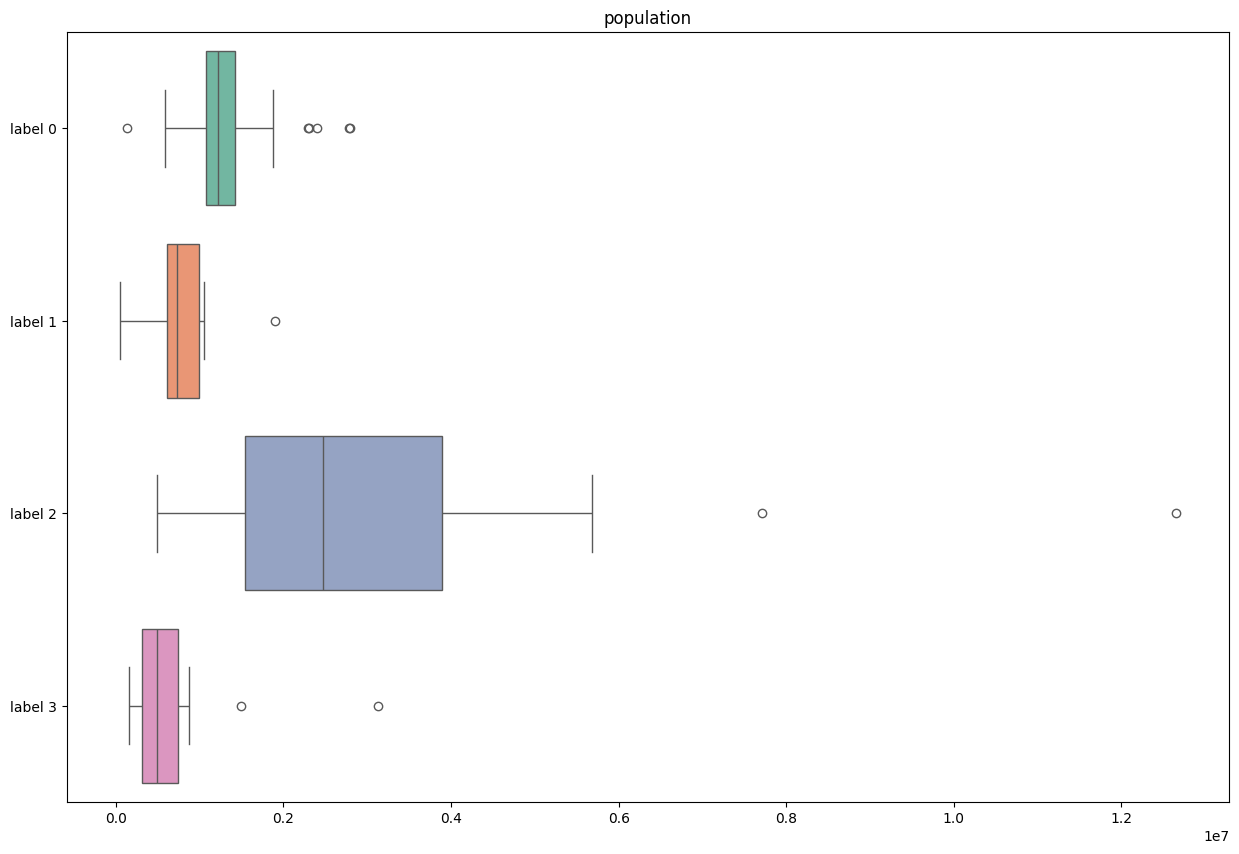

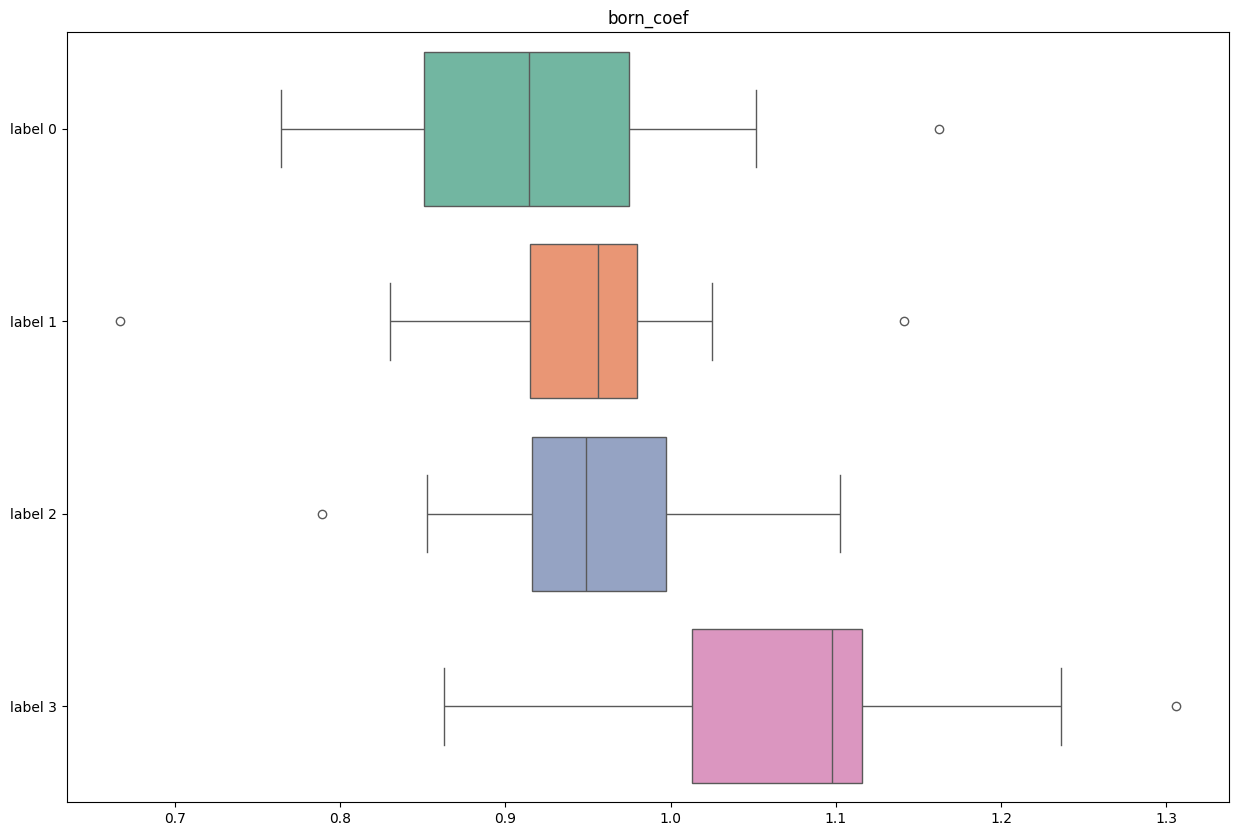

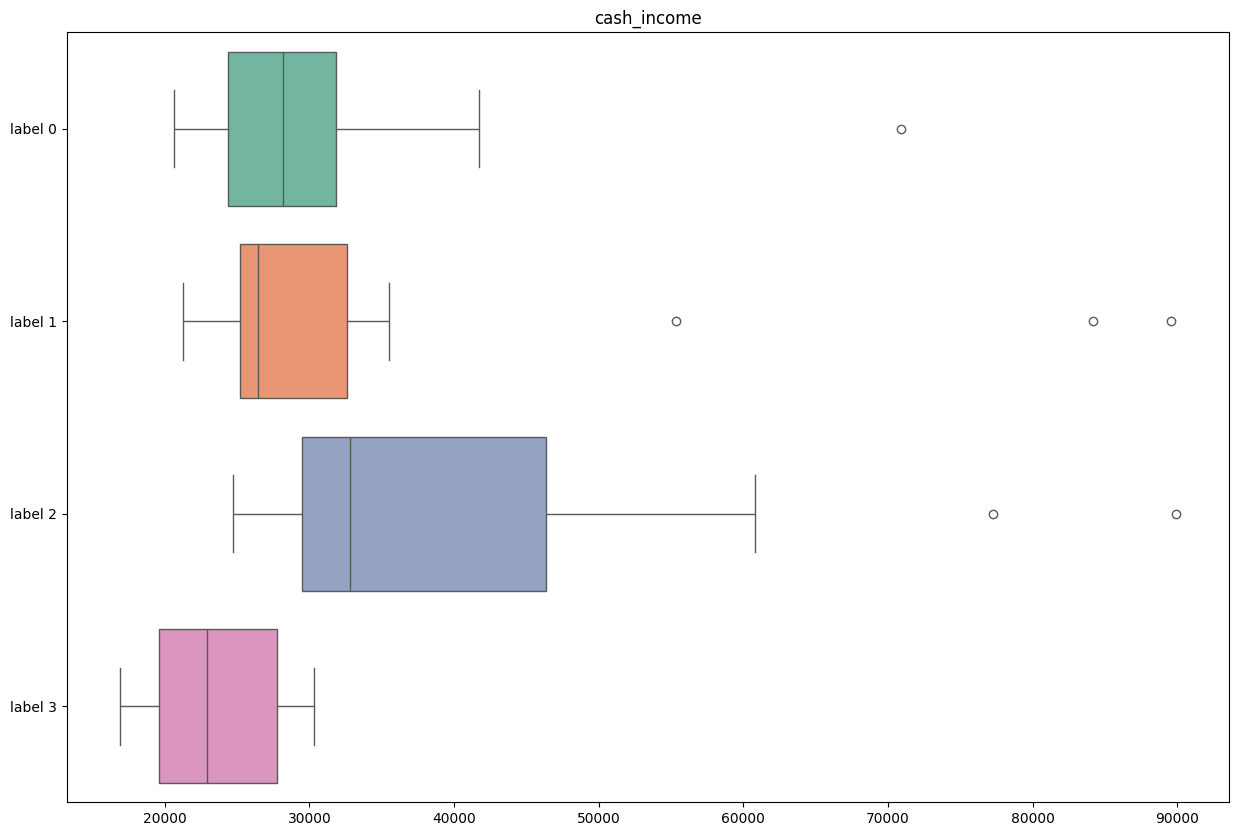

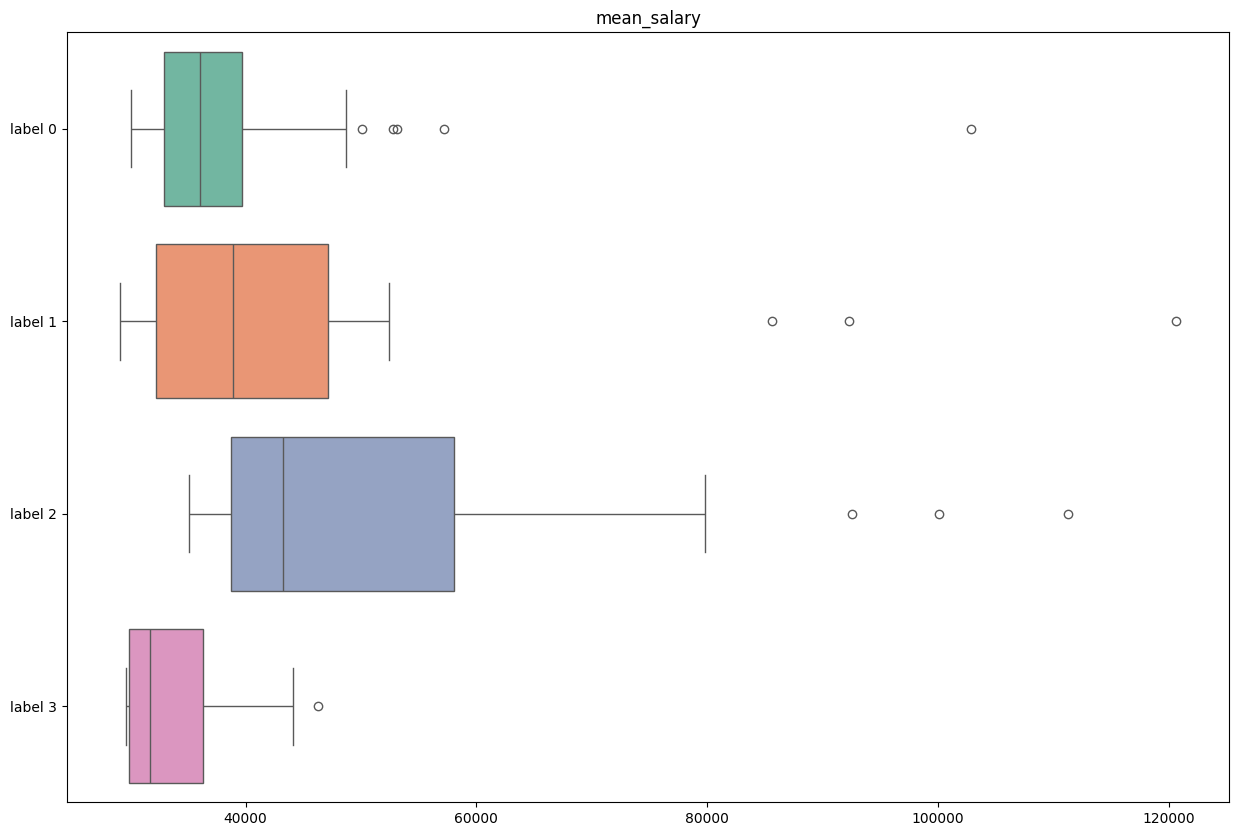

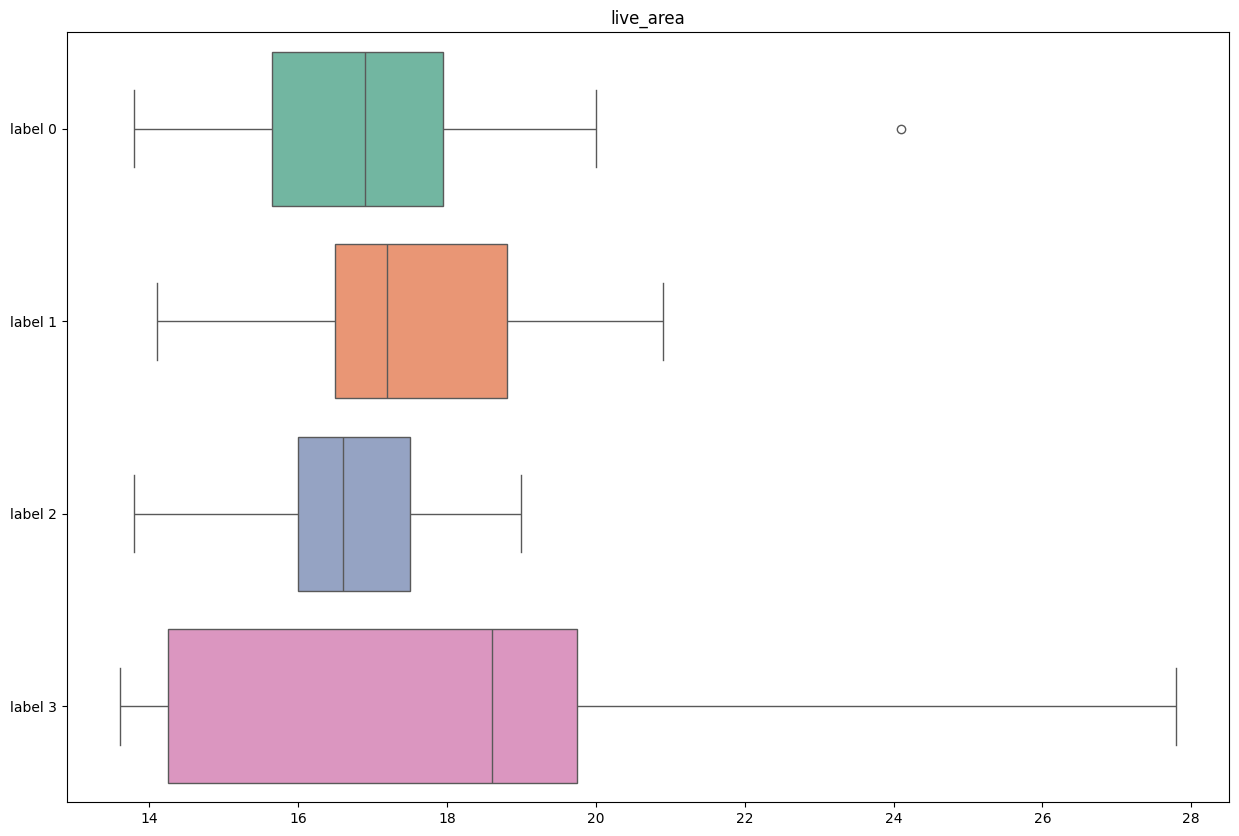

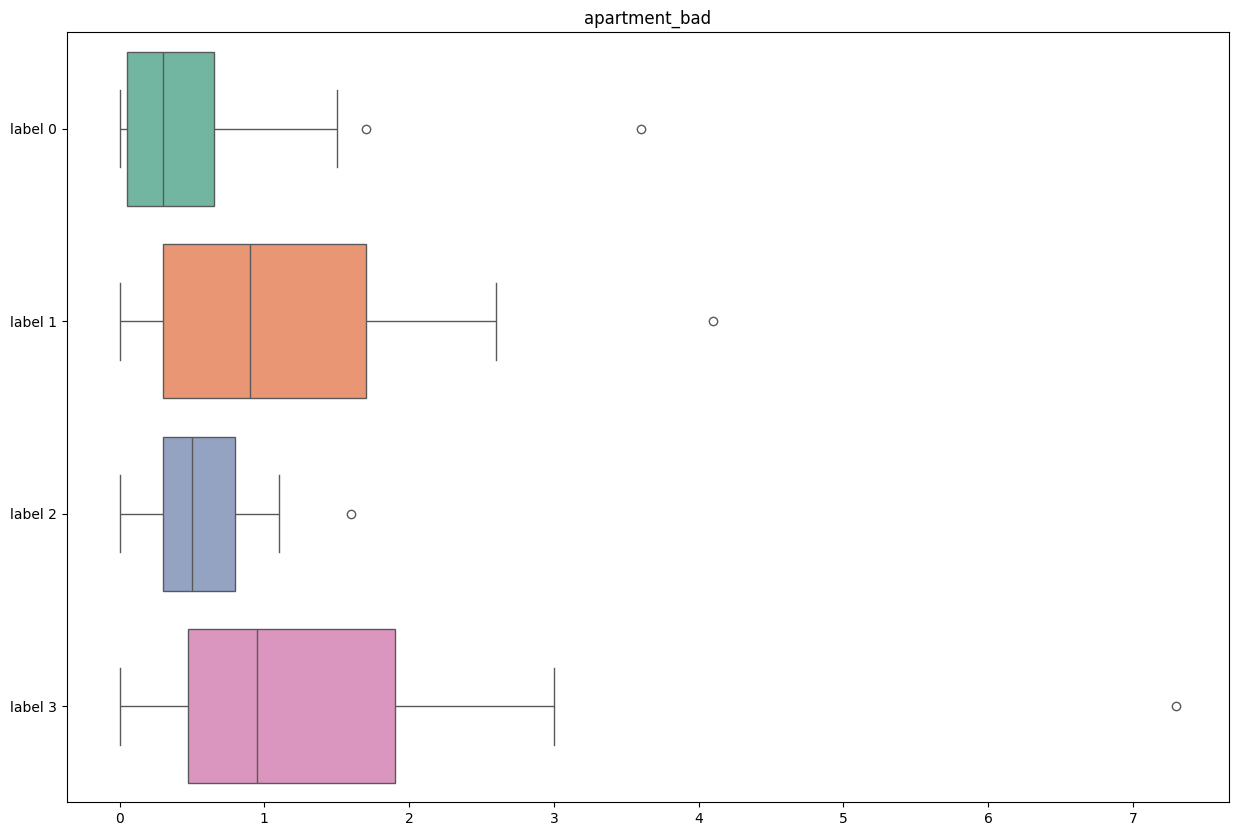

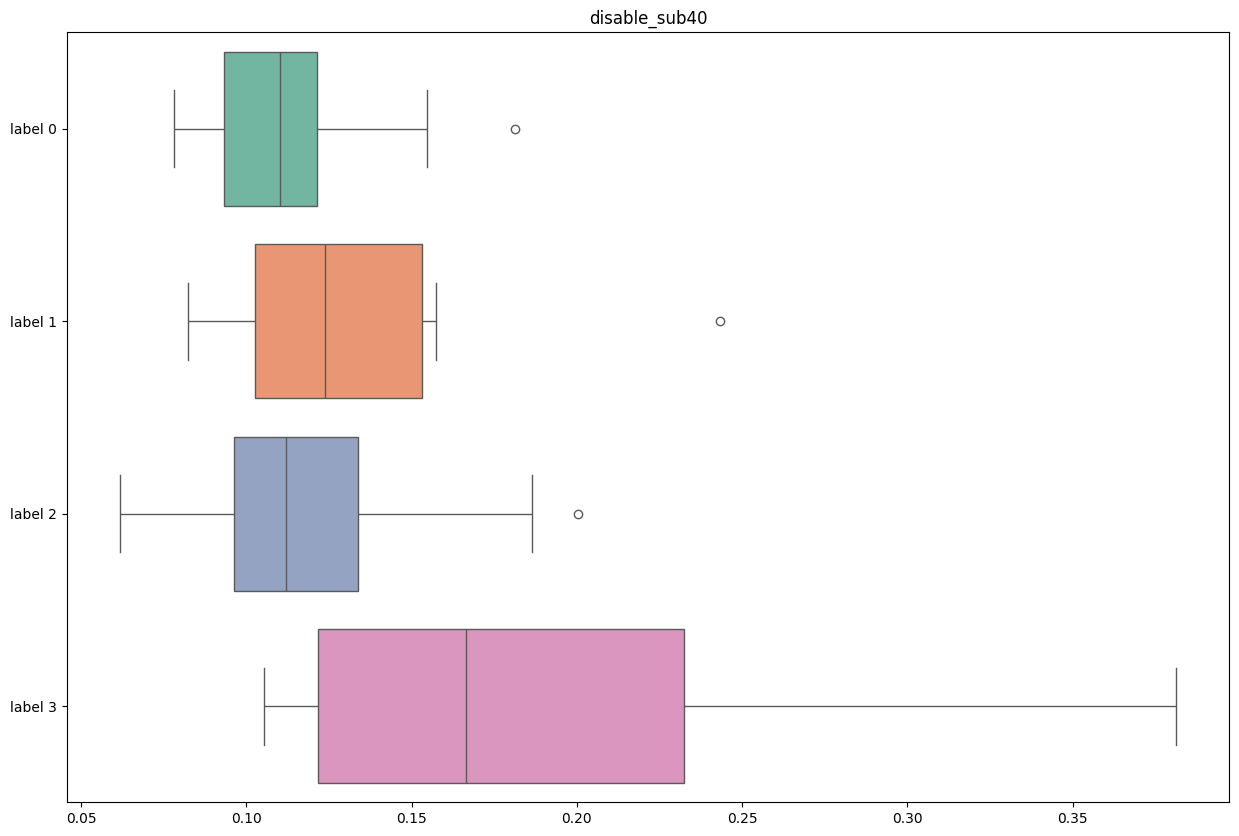

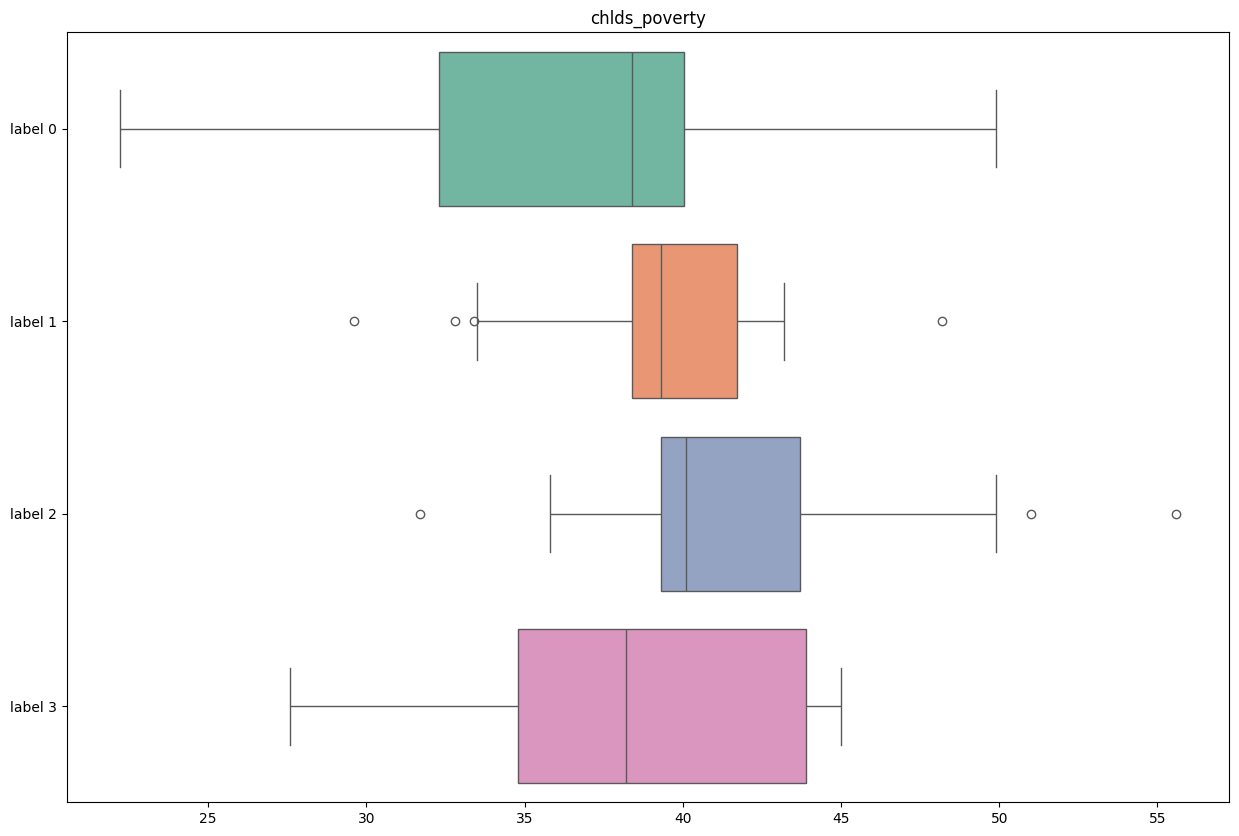

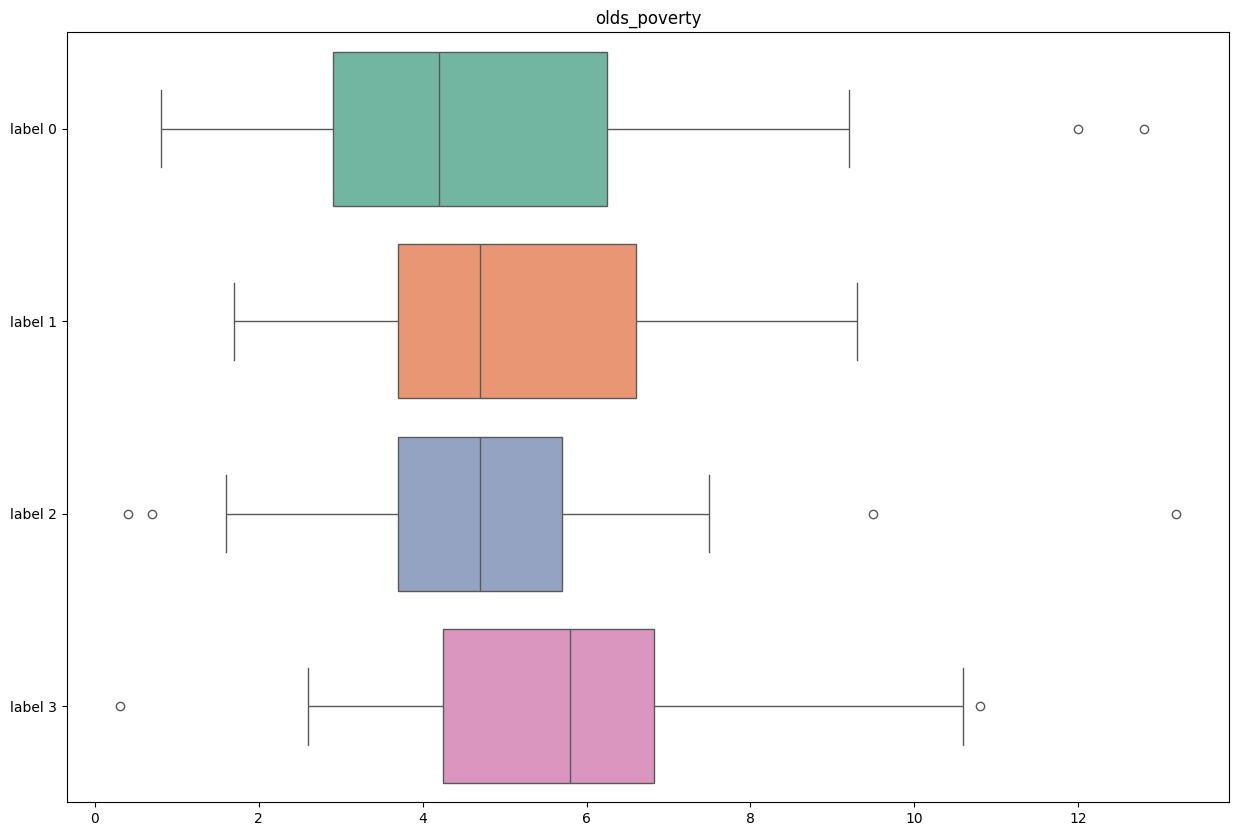

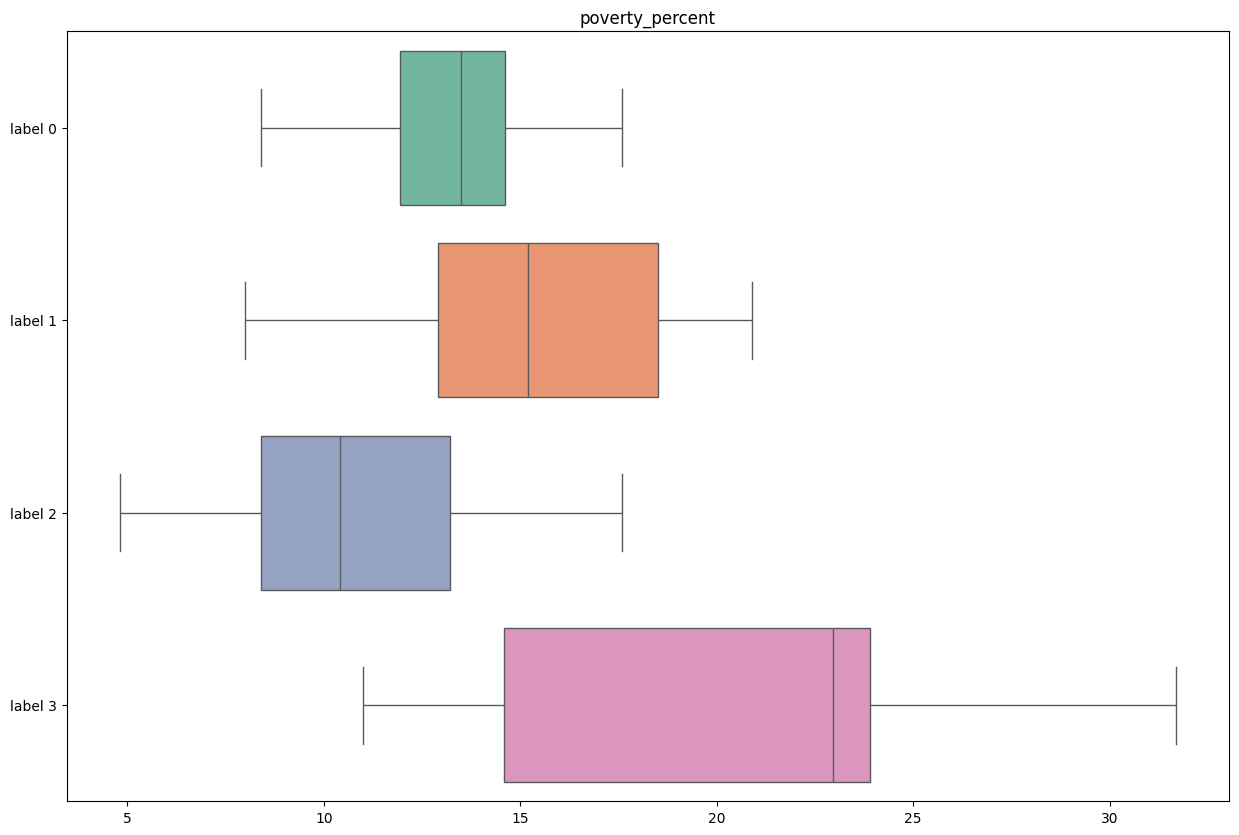

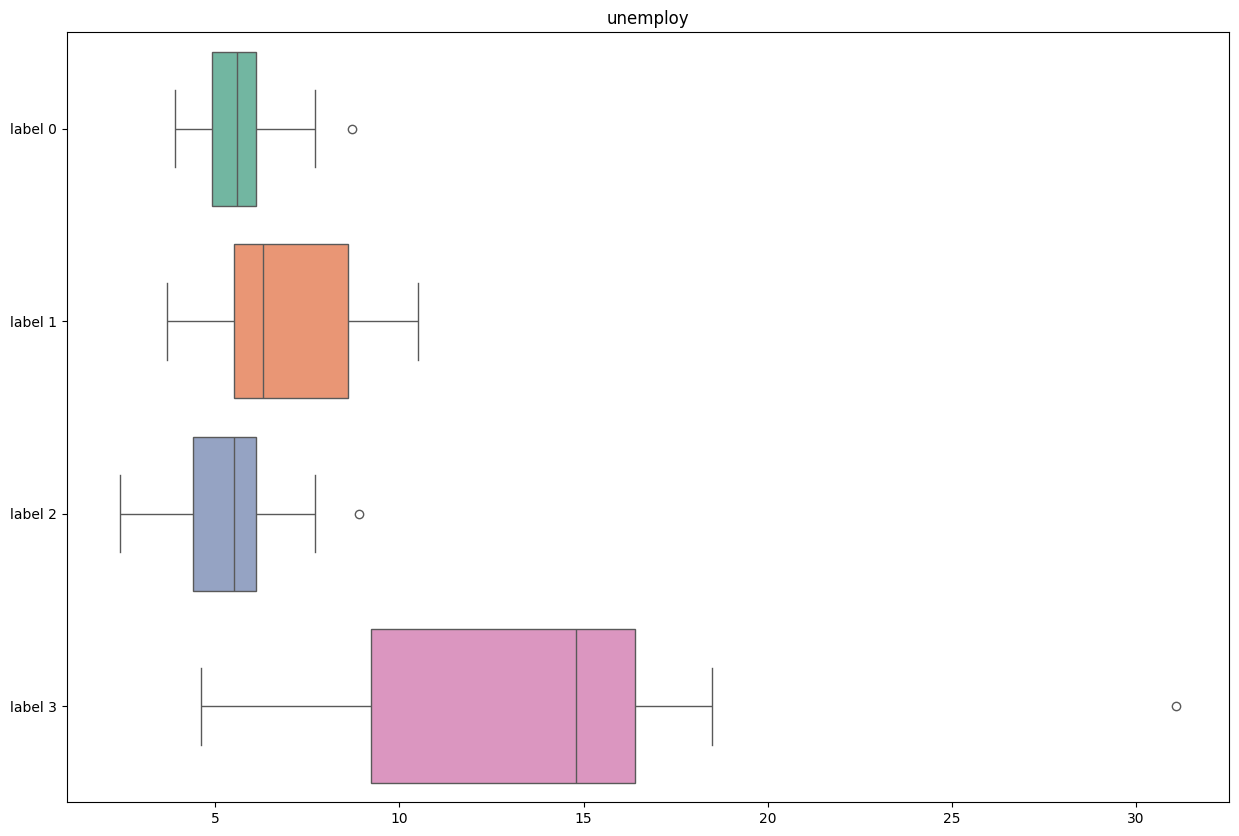

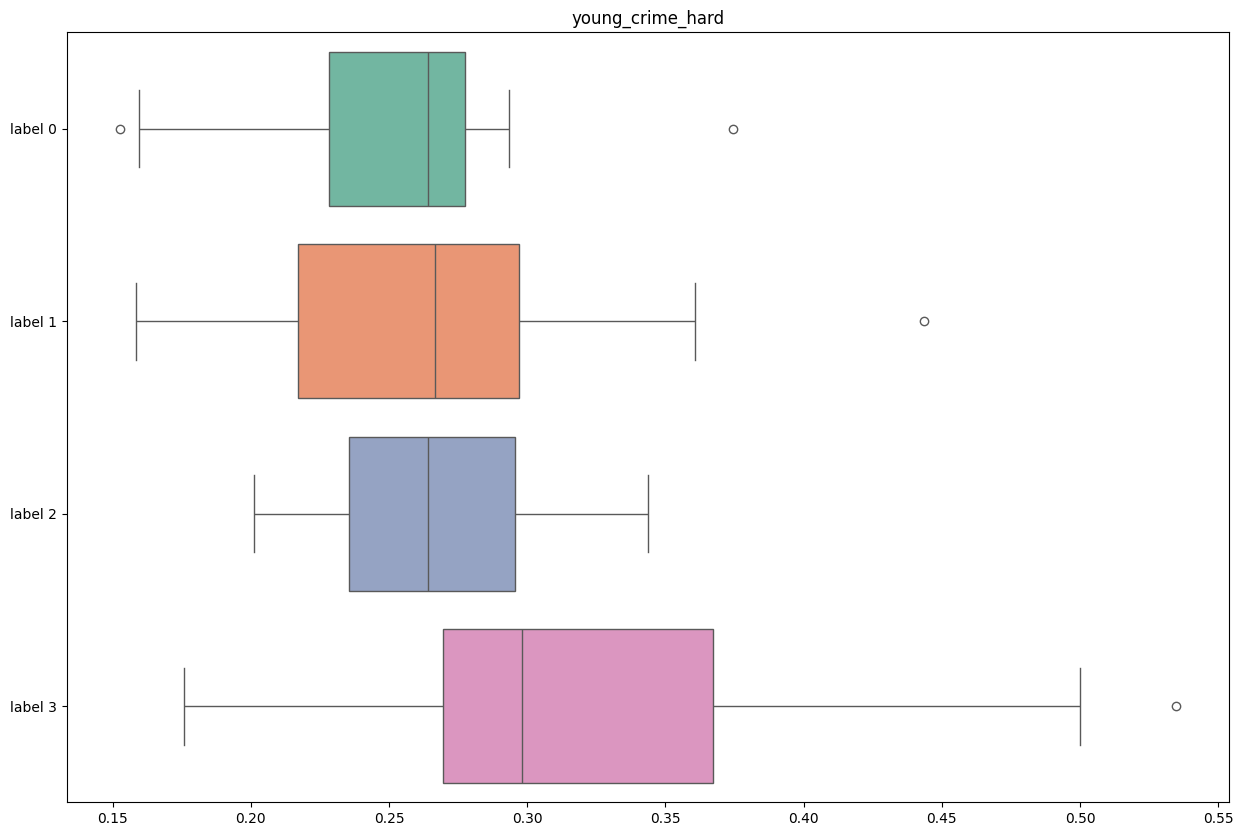

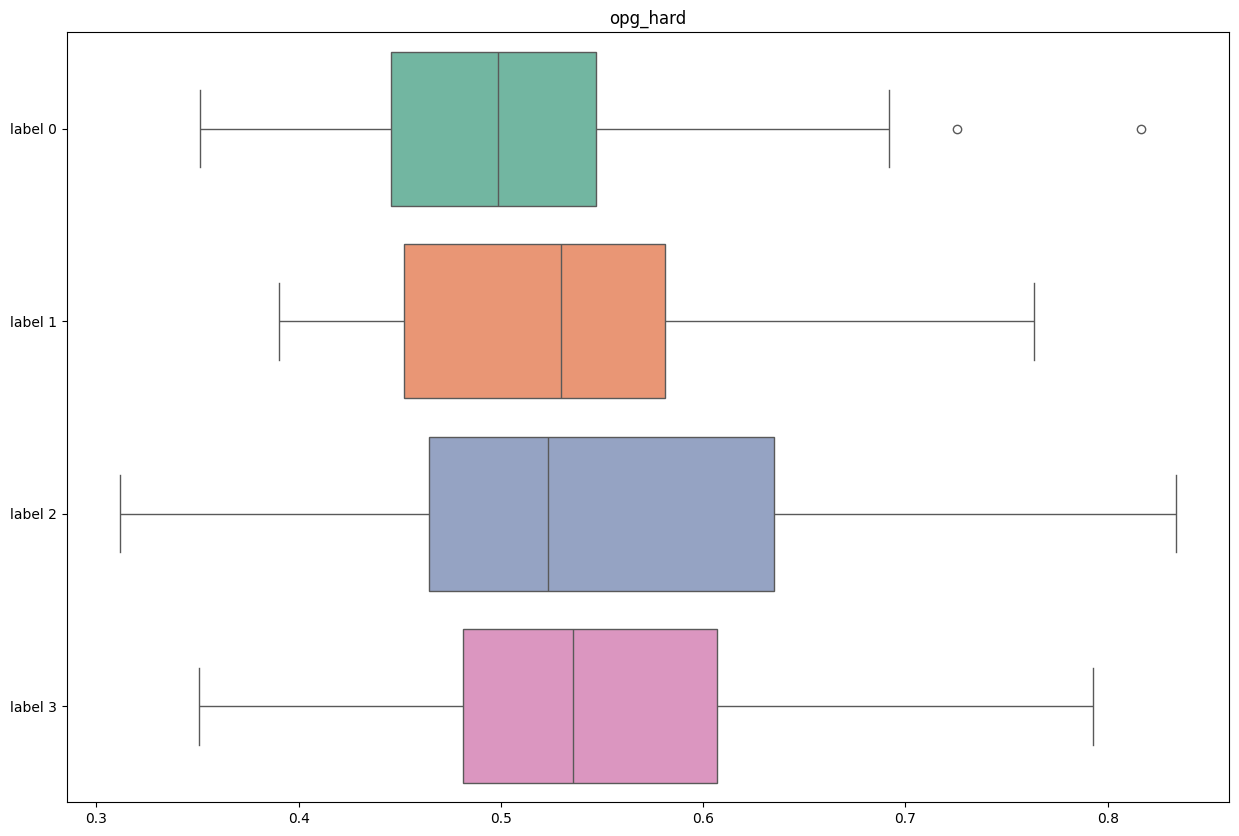

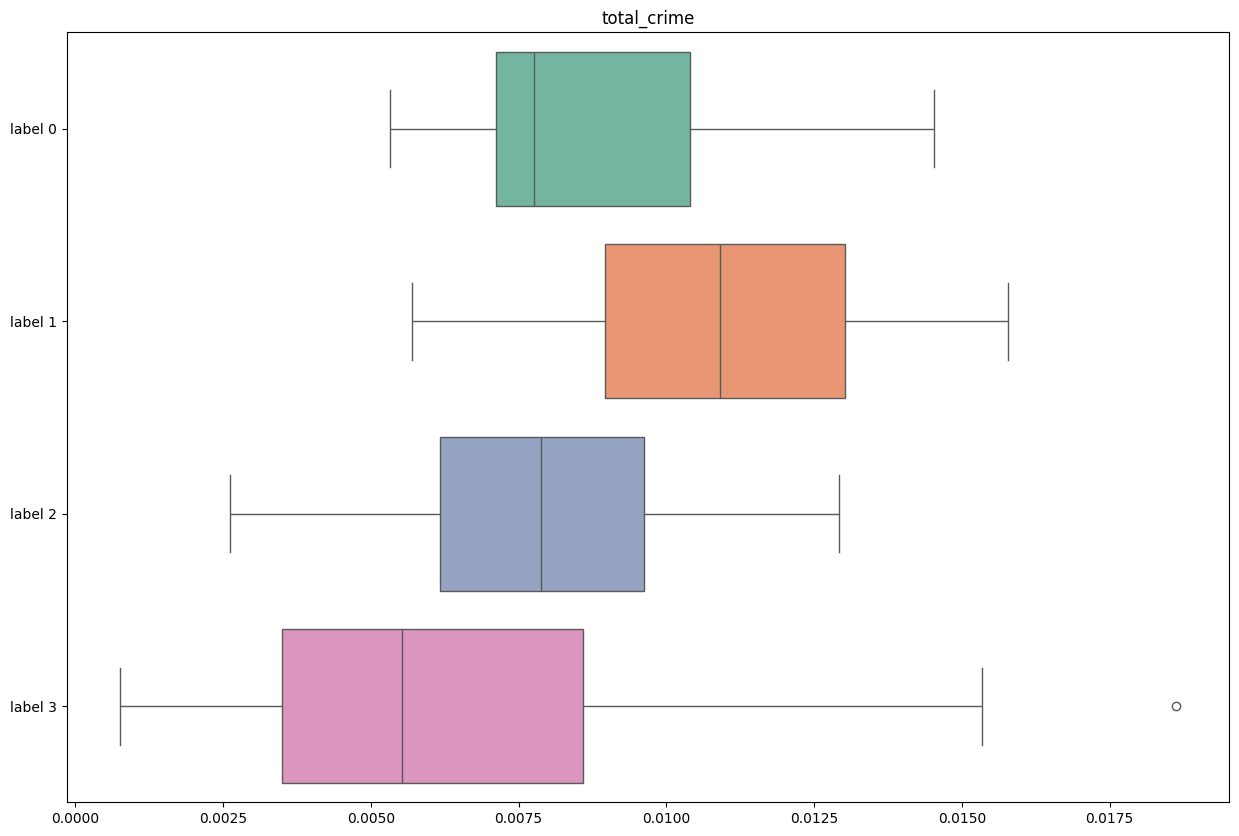

In [27]:
show_stat("population")
show_stat("born_coef")
show_stat("cash_income")
show_stat("mean_salary")
show_stat("live_area")
show_stat("apartment_bad")
show_stat("disable_sub40")
show_stat("chlds_poverty")
show_stat("olds_poverty")
show_stat("poverty_percent")
show_stat("unemploy")
show_stat("young_crime_hard")
show_stat("opg_hard")
show_stat("total_crime")

# Выводы:

*Данные неплохо кластеризовались на 4 группы. Исходя из задания, выше представлены графики по кластерам и основным распределениям. В контексте задания самые незащищённые социальные группы, с самыми низкими показателями по доходам, зарплатам и, в то-же время, с самыми высокими показателями бедности, безработицы и криминагенной обстановки в кластере 3*